In [ ]:
from rdflib import Graph, URIRef, Literal, Namespace
g = Graph()

ALIGNMENT_RDF_FILE_PATH = "../XP/bok-groq.ttl"
COURSES_RDF_FILE_PATH = "../data/courses_splitted.ttl"


g.parse(ALIGNMENT_RDF_FILE_PATH, format="turtle")
g.parse(COURSES_RDF_FILE_PATH, format="turtle")

print(f"Graph loaded : {g.__len__()} triples")

Graph loaded : 8475 triples


In [7]:
distinct_ue= """
PREFIX ns1: <http://example.org/course/>

SELECT (COUNT(DISTINCT ?s) AS ?nb_UE)
WHERE {
  ?s ns1:content ?content .
}
"""

empty_content= """
PREFIX ns1: <http://example.org/course/>

SELECT (COUNT(?s) AS ?nb_sujets_courts)
WHERE {
  ?s ns1:content ?content .
  FILTER(STRLEN(STR(?content)) < 10)
}
"""

qres = g.query(distinct_ue)
for row in qres:
    print(f"Number of distinct UE: {row.nb_UE}")

qres = g.query(empty_content)
for row in qres:
    print(f"Number of short content: {row.nb_sujets_courts}")

Number of distinct UE: 94
Number of short content: 42


In [15]:
aligned_ue= """
prefix ns1: <http://provo.org/> 
prefix ns2: <http://example.org/course/> 
prefix ns3: <http://align.org/> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?ue ?parcours ?ku ?ka
WHERE {
  ?ue ns2:parcours  ?parcours .
  ?ue ns3:to [
    ns2:answer "1" ;
    ns2:ku ?ku ;
    ns2:ka ?ka ;
    ns1:wasGeneratedBy [ ns1:used "llama3-8b-8192" ]
  ] .
} limit 10
"""
qres = g.query(aligned_ue)
for row in qres:
    print(f"UE: {row.ue}, ?parcours {row.parcours}, KU: {row.ku}, KA: {row.ka}")

UE: http://example.org/course/X1CI010, ?parcours CMI, KU: AR-Representation_Machine-Level_Data_Representation, KA: Architecture_and_Organization_AR
UE: http://example.org/course/X1CI010, ?parcours CMI, KU: SPD-Common_Aspects, KA: Specialized_Platform_Development_SPD
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: SF-Basic_Concepts, KA: System_Fundamentals_SF
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: FPL-Functional_Functional_Programming, KA: Foundations_of_Programming_Languages_FPL
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: MSF-Linear_Linear_Algebra, KA: Mathematical_and_Statistical_Foundations_MSF
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: SE-Software_Development, KA: Software_Engineering_SE
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: SDF-Software_Development_Practices, KA: Software_Development_Fundamentals_SDF
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: FPL-Methodologies_Formal_Development_Metho

In [21]:
radar_llama3_8b= """
prefix ns1: <http://provo.org/> 
prefix ns2: <http://example.org/course/> 
prefix ns3: <http://align.org/> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT  ?parcours ?ka (count(distinct ?ku) as ?nb_ku)
WHERE {
  ?ue ns2:parcours  ?parcours .
  ?ue ns3:to [
    ns2:answer "1" ;
    ns2:ku ?ku ;
    ns2:ka ?ka ;
    ns1:wasGeneratedBy [ ns1:used "llama3-8b-8192" ]
  ] .
} group by ?parcours ?ka
"""
radar_data = g.query(radar_llama3_8b)
for row in radar_data:
    print(f"Parcours: {row.parcours}, KA: {row.ka}, KU: {row.nb_ku}")

Parcours: CMI, KA: Architecture_and_Organization_AR, KU: 2
Parcours: CMI, KA: Specialized_Platform_Development_SPD, KU: 3
Parcours: ALMA, KA: System_Fundamentals_SF, KU: 1
Parcours: ALMA, KA: Foundations_of_Programming_Languages_FPL, KU: 8
Parcours: ALMA, KA: Mathematical_and_Statistical_Foundations_MSF, KU: 4
Parcours: ALMA, KA: Software_Engineering_SE, KU: 6
Parcours: ALMA, KA: Software_Development_Fundamentals_SDF, KU: 3
Parcours: ALMA, KA: Date_Management_DM, KU: 6
Parcours: ATAL, KA: Date_Management_DM, KU: 5
Parcours: DS, KA: Date_Management_DM, KU: 5
Parcours: VICO, KA: Date_Management_DM, KU: 4
Parcours: ALMA, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: ATAL, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: DS, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: VICO, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: ALMA, KA: Specialized_Platform_Development_SPD, KU: 4
Parcours: ATAL, KA: Specialized_Platform_Development_SPD, KU: 4
Parcours: DS, KA: Specialized_Platform_Developme

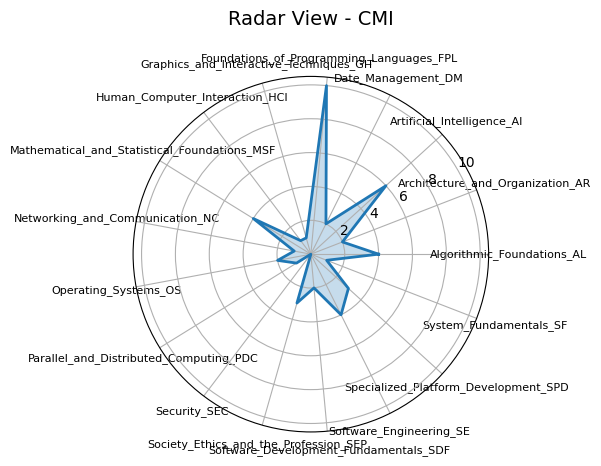

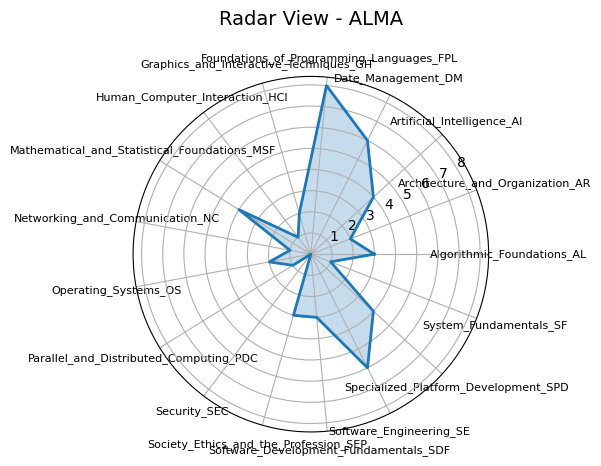

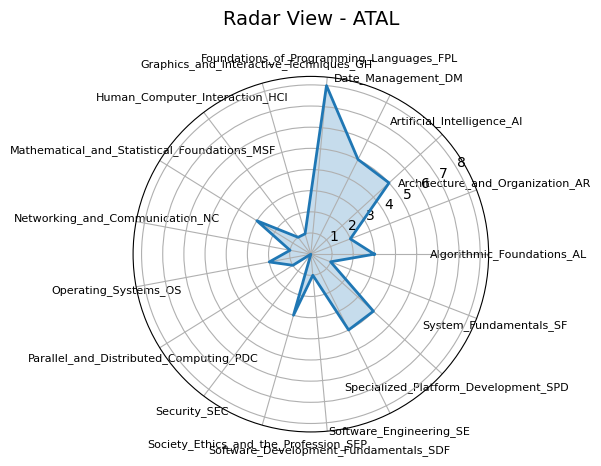

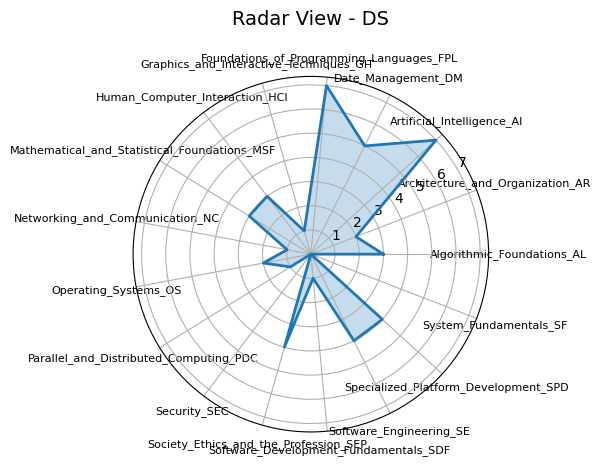

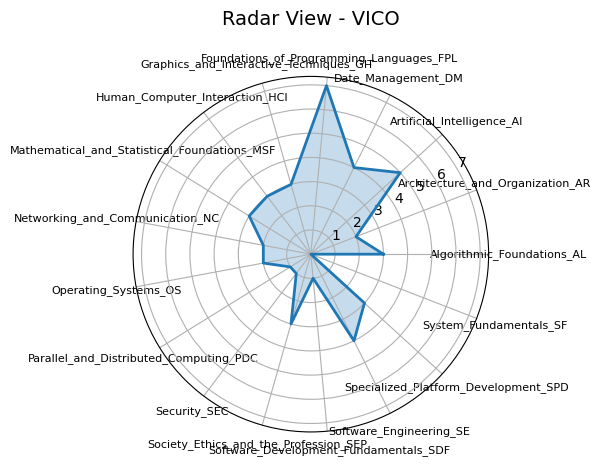

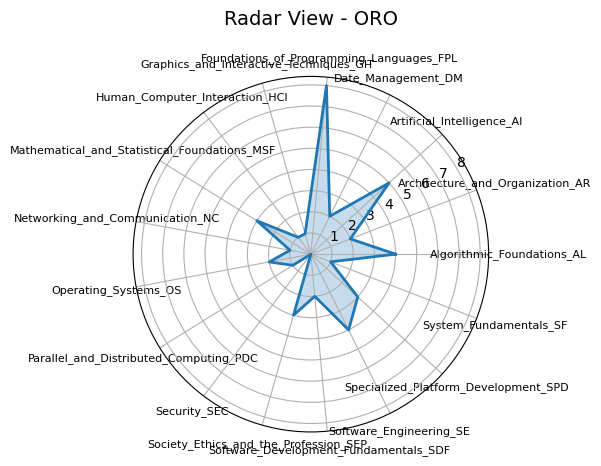

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 1. Collecte des résultats de la requête
data = defaultdict(dict)  # {parcours: {ka: nb_ku}}

for row in radar_data:
    parcours = str(row.parcours)
    ka = str(row.ka)
    nb_ku = int(row.nb_ku)
    data[parcours][ka] = nb_ku

# 2. Construction de l'ensemble des axes (toutes les KA rencontrées)
all_kas = sorted({ka for parcours_data in data.values() for ka in parcours_data})

# 3. Plot radar chart par parcours
def radar_factory(num_vars):
    # angles equally spaced around the circle
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop
    return angles

angles = radar_factory(len(all_kas))

for parcours, ka_dict in data.items():
    values = [ka_dict.get(ka, 0) for ka in all_kas]
    values += values[:1]  # boucler le graphe

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, label=parcours)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_kas, fontsize=8, wrap=True)
    ax.set_title(f"Radar View - {parcours}", size=14, pad=20)
    ax.set_rlabel_position(30)
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [23]:
consensus_align="""
PREFIX ns1: <http://provo.org/> 
PREFIX ns2: <http://example.org/course/> 
PREFIX ns3: <http://align.org/>

SELECT DISTINCT ?ue ?ku
WHERE {
  # Tous les modèles ayant donné un avis ont répondu "1"
  ?ue ns3:to [
    ns2:ku ?ku ;
    ns2:answer "1"
  ] .

  # Il ne doit exister aucun modèle ayant répondu "0" sur cette paire
  FILTER NOT EXISTS {
    ?ue ns3:to [
      ns2:ku ?ku ;
      ns2:answer "0"
    ]
  }
}
"""
qres = g.query(consensus_align)
for row in qres:
    # On affiche les UE et KU qui ont un consensus
    # d'alignement (tous les modèles ont répondu "1" et aucun n'a répondu "0")
    print(f"UE: {row.ue}, KU: {row.ku}")

UE: http://example.org/course/X1I1020, KU: SE-Software_Development
UE: http://example.org/course/X1I1040, KU: SPD-Web_Platforms
UE: http://example.org/course/X1II030, KU: AL-Complexity_Complexity
UE: http://example.org/course/X1II070, KU: MSF-Calculus
UE: http://example.org/course/X2I3010, KU: OS-Concurrency_Concurrency
UE: http://example.org/course/X2II030, KU: FPL-Syntax_Syntax_Analysis
UE: http://example.org/course/X3IT040, KU: AI-NLP_Natural_Language_Processing
UE: http://example.org/course/YG9U15-, KU: AI-Vision_Perception_and_Computer_Vision
UE: http://example.org/course/ZZ3CG, KU: GIT-Fundamentals
UE: http://example.org/course/ZZHCI, KU: HCI-Evaluation_Evaluating_the_Design
